# CSC311 Lab 6: Music Generation with a Multi-Layer Perceptron

In this lab, we will build a simple multi-layer perceptron to predict the next
note in a piece of classical music given the previous 20 notes.
Though limited, this model can be used repeatedly as a rudimentary
way to generate music.

This is by no means the best method for music generation. In CSC413 we will cover
Recurrent Neural Networks (RNN), which makes it possible for a model to "remember"
past more than a previous set number of notes. In CSC413, we will also study
Transformers, an even more powerful architecture that is currently the state of the art
for natural language tasks.

By the end of this tutorial, you will be able to:

1. Implement a two-layer neural network with fully-connected layers (MLP) in `numpy`
2. Vectorize the neural network forward pass to compute predictions for a batch of data.
3. Vectorize the backpropagation computation to compute gradients updates for a two-layer MLP.
4. Apply gradient descent to minimize the loss function of a MLP.
5. Explain the limitation of a simple MLP model architectures for a complex task like music generation.

Please work in groups of 1-2 during the tutorial.

Acknowledgements:

- Data is from https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Submit the ipynb file `lab06.ipynb` on Markus
**containing all your solutions to the Graded Task**s.
Your notebook file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 2. Your implementation of the `softmax` function (1 point)
- Part 2. Your annotations of the shapes of each forward- and backward-pass quantity (1 point)
- Part 2. Your implementation of the `do_forward_pass` function (2 points)
- Part 2. Your implementation of the `generate_piece` function (1 point)
- Part 3. Your implementation of the `do_backward_pass` function (3 points)
- Part 4. Your training curve on a single batch of data (1 point)
- Part 6. Your discussion of the limitations of this architecture (1 point)

You may produce a PDF document by exploring the Colab document, but be careful to check
that the required code and output is not cut off.
This method is preferred, since we would be able to more easily help point out issues.

Alternatively, you may create a PDF document that contain the parts that are graded.
However, the feedback we are able to provide may be more limited.

## Google Colab Setup

Since we will be working with music data, you will need to install a few libraries
to be able to read and write midi files. Recall that on Google Colab, we use
"!" to run shell commands.
Below, we use such commands to install a few Python packages.

In [ ]:
# For reading and writing midi files
!pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.5 MB/s eta 0:00:00


We will install a few more packages to write the `play_midi` function, which will play a midi file directly on Google Colab.
You do not need these packages to complete the lab, only to play the training and generated midi files.

In [ ]:
# For playing midi files on Google Colab
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icc

In [ ]:
from midi2audio import FluidSynth
from IPython.display import Audio

def play_midi(midi_filename):
    """Call `play_midi` with a path to a midi file will show a midi player on Google Colab."""
    FluidSynth("font.sf2").midi_to_audio(midi_filename, 'test.wav')
    return Audio("test.wav")

And let's not forget our trusty numpy and other useful imports!

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Part 1. Data

As always, we need to download our data set.

In [ ]:
# Download tutorial data files.
!wget https://www.cs.toronto.edu/~lczhang/311/lab06/data.zip

# Unzip the zip file.
!unzip data.zip

--2025-02-22 22:36:05--  https://www.cs.toronto.edu/~lczhang/311/lab06/data.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488274 (477K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 476.83K  3.01MB/s    in 0.2s    

2025-02-22 22:36:05 (3.01 MB/s) - ‘data.zip’ saved [488274/488274]

Archive:  data.zip
   creating: data/
   creating: data/chopin/
  inflating: __MACOSX/data/._chopin  
   creating: data/debussy/
  inflating: __MACOSX/data/._debussy  
  inflating: data/chopin/chpn-p22_simplified.mid  
  inflating: data/chopin/chpn_op23.mid  
  inflating: __MACOSX/data/chopin/._chpn_op23.mid  
  inflating: data/chopin/chpn-p19.mid  
  inflating: __MACOSX/data/chopin/._chpn-p19.mid  
  inflating: data/chopin/chpn_op7_2.mid  
  inflating: __MACOSX/data/chopin/._chpn_op7_2.mid  
  inflating

This data set consists of midi files of piano pieces composed by two classical
composers: Chopin and Debussy. Musicians in this course will find that the pieces
have been grossly simplified: each note has been changed to have the same loudness
and duration. This is so that each piece of music can be represented as a sequence
of notes in a straightforward way.

As an example, let's play the simplified rendition of one of Chopin's pieces.

Compared to the original, non-simplified version:

Just like with images, our computer represents music as a sequence of numbers.
We represent each piece of music as a sequence of **notes**.
In a midi file, each note's pitch is represented using an integer from 0-127.
You can think of each note (e.g. each key on a piano) as having a unique integer identifier.
The larger the integer identifier, the higher the pitch.

For folks who happen to know a bit about musical notes, the identifier 60 represents the middle C:

![](https://www.audiolabs-erlangen.de/resources/MIR/FMP/data/C1/FMP_C1_MIDI-NoteNumbers.png)

The function for extracting the notes from a midi file is written for you. The
file `get_midi_file_notes` takes a `.midi` filename and returns the sequence of
notes in that file.

In [ ]:
from mido import MidiFile, MidiTrack

def get_midi_file_notes(filename):
    """Returns the sequence of notes played in the midi file
    There are 128 possible notes on a MIDI device, and they are numbered 0 to 127.
    The middle C is note number 60. Larger numbers indiciate higher pitch notes,
    and lower numbers indicate lower pitch notes.

    You can read more about the midi representation below, but it is not
    necessary for this assignment.
    http://midi.teragonaudio.com/tech/midispec/noteon.htm
    """
    notes = []
    for msg in  MidiFile(filename):
        if msg.type == 'note_on':
            notes.append(msg.note)
    return notes

**Task**: Run the code below to print the sequence of notes for these two files.
Explain why the two output sequences have **different** lengths.

In [ ]:
print(get_midi_file_notes('data/chopin/chpn-p1_simplified.mid'))
print(get_midi_file_notes('data/chopin/chpn-p2_simplified.mid'))

# The length of the two music piece are different

[36, 55, 43, 60, 52, 67, 64, 60, 69, 57, 35, 55, 43, 62, 53, 67, 65, 62, 69, 57, 36, 55, 43, 60, 52, 67, 64, 60, 69, 57, 40, 59, 52, 64, 55, 71, 67, 64, 72, 60, 41, 64, 52, 69, 57, 76, 72, 69, 62, 74, 42, 64, 50, 69, 60, 76, 72, 69, 62, 74, 43, 64, 53, 67, 59, 76, 71, 67, 62, 74, 31, 59, 43, 62, 53, 71, 65, 62, 69, 57, 36, 55, 43, 60, 52, 67, 64, 60, 69, 57, 35, 55, 43, 62, 53, 67, 65, 62, 69, 57, 36, 55, 43, 60, 52, 67, 64, 60, 69, 57, 40, 59, 52, 64, 55, 71, 67, 64, 72, 60, 41, 61, 48, 65, 57, 73, 69, 65, 62, 74, 43, 63, 48, 67, 58, 75, 72, 67, 76, 64, 45, 67, 53, 69, 60, 79, 72, 69, 65, 77, 43, 63, 48, 67, 60, 75, 72, 67, 64, 76, 45, 64, 53, 69, 60, 76, 72, 69, 65, 77, 66, 47, 55, 71, 62, 78, 74, 71, 67, 79, 68, 48, 55, 72, 64, 80, 76, 72, 69, 81, 70, 50, 55, 74, 65, 82, 79, 74, 71, 83, 52, 74, 60, 76, 67, 86, 79, 76, 72, 84, 42, 71, 51, 72, 60, 83, 75, 72, 69, 81, 69, 43, 52, 72, 60, 81, 76, 72, 67, 79, 43, 64, 53, 67, 59, 76, 71, 67, 62, 74, 55, 36, 43, 60, 52, 67, 64, 60, 69, 57,

Now that we have represented a piece of music as a sequence of notes, we can
begin generating our labelled data. We would like to predict the
next note in a piece of classical music given the previous 20. To be able to
train a neural network to perform such a task, we would need labelled data
of the form:

- Input $\bf{x}$: A sequence of 20 notes in the piece of music.
- Output $t$: The next note in the piece of music.

The sequence of 20 notes is sometimes called the *context* used to predict the next note.
The length of this sequence is called the *context length*.
We will treat this number as a constant, but write our code to make it easy to experiment
with other context lengths.

In [ ]:
CONTEXT_LENGTH = 20

To create labelled data in this form, we'll iterate over a musical piece, and generate
all possible data points $(\bf{x}, t)$ of the previous 20 notes and the corresponding following note.

In [ ]:
def gen_input_output(notes, context_length=CONTEXT_LENGTH):
    """
    Generate a list of training data points, each of the form (x, t),
    where "x" is a list of length `context_length` consisting of the
    previous notes, and "t" is the corresponding next note.

    Parameters:
        `notes` - a sequence of notes in a piece, generated
                  from calling `get_midi_file_notes`
        `context_length` - length of each context

    Returns: a list of training pairs (x, t), with len(x) == context_length
    """
    D = []
    for i in range(len(notes) - context_length):
        seq = notes[i:i+context_length]
        next_note = notes[i+context_length]
        D.append((seq, next_note),)

    D.append((notes[-context_length:], 0),)
    # Since the note 0 never appears in any of our pieces,
    # we use note 0 to denote END OF SONG. In general, we choose
    # a special value to denote the END OF SONG (usually a new
    # category that doesn't match an actual note), so that our
    # model might learn to end a song.
    return D

**Task** To test the function `gen_input_output`, construct the training pairs for a single musical piece by Chopin.

In [ ]:
notes_chpnop23 = get_midi_file_notes('data/chopin/chpn_op23_simplified.mid')

D_chpnop23 = gen_input_output(notes_chpnop23)

# Since we are taking all possible subsequences of length (CONTEXT_LENGTH + 1)
# of the sequence `notes`, the following two values should be the same
print(len(notes_chpnop23))
print(len(D_chpnop23) + CONTEXT_LENGTH - 1)

5028
5028


It may appear that we have our inputs and targets formatted appropriately.
However, although notes have an ordering to them, they are actually more like categorical features than numeric ones.
Treating notes as categorical values will help our model detect more patterns independent to their pitch.

To that end, we will create indicator variables for each of these notes.

In [ ]:
def make_onehot(indicies, total=128):
    """
    Convert indicies into one-hot vectors by
    first creating an identity matrix of shape [total, total],
    then indexing the appropriate columns of that identity matrix.

    Parameters:
        `indices` - a numpy array of some shape where
                    the value in these arrays should correspond to category
                    indices (e.g. note values between 0-127)
        `total` - the total number of categories (e.g. total number of notes)

    Returns: a numpy array of one-hot vectors
        If the `indices` array is shaped (N,)
           then the returned array will be shaped (N, total)
        If the `indices` array is shaped (N, D)
           then the returned array will be shaped (N, D, total)
        ... and so on.
    """
    I = np.eye(total)
    return I[indicies]

**Task**:
Now that we have these functions,
generate a small training data set from that one Chopin piece from earlier:

In [ ]:
def get_X_t(D):
    """
    Generate the data matrix "X" and target vector "t" from a data set "D",

    Parameters:
        `D` - a list of pairs of the form (x, t), returned from
              the function `gen_input_output`

    Returns: a tuple (X, t) where
        `X` - a numpy array of shape (N, D), the data matrix
        `t` - a numpy array of shape (N,),
              with each value representing the index of the target note
    """
    t = np.array([next_note for seq, next_note in D])
    X_ids = np.array([seq for seq, next_note in D])
    X = make_onehot(X_ids)
    X = X.reshape(X.shape[0], -1)
    return X,t

X_chpnop23, t_chpnop23 = get_X_t(D_chpnop23)

You should see that the shape of X_chpnop23 is (5009, 2560). This is because a single notes sequence vector with shape (20,) must first get 1-hot encoded, making the new shape (20, 128). We then horizontally stack the 1-hot vectors into a single vector of shape (2560,) which is what np.reshape() does in the above function.

This above data set only contains information about a single musical piece, rather than
from all Chopin pieces in our data set. However, starting with a small data set will
help us while we build and debug our model in Part 4.
We will move on to use the full data set in Part 5.

## Part 2. Model Building: Forward Pass

In this section, we will build our 2-layer MLP machine learning model. We will start by writing the important softmax helper function, and then move on to writing the forward pass of the MLP.
We will write the backward-pass and train the model in Part 3 and 4.
But before then, we can test the forward pass of our model by evaluating an
untrained MLP model.

**Graded Task** Complete the function `softmax`. For numerical stability, instead of
computing
$y_k = \frac{e^{z_k}}{\sum_{l} e^{z_l}}$, we will instead take
$m = \max_l z_l$ and compute:
$y_k = \frac{e^{(z_k-m)}}{\sum_{l} e^{(z_l-m)}}$.

In [ ]:
def softmax(z):
    """
    Compute the softmax of vector z, or row-wise for a matrix z.
    For numerical stability, subtract the maximum logit value from each
    row prior to exponentiation (see above).

    Parameters:
        `z` - a numpy array of shape (K,) or (N, K)

    Returns: a numpy array with the same shape as `z`, with the softmax
        activation applied to each row of `z`
    """
    z_max = np.max(z, axis=-1, keepdims=True)
    z_exp = np.exp(z - z_max)
    return z_exp / np.sum(z_exp, axis=-1, keepdims=True)

Now we are ready to implement the MLP model. Mathematically, here is how our
model will produce a prediction given a single input ${\bf x}$:
\begin{align*}
{\bf m} &=  W^{(1)}{\bf x} + {\bf b}^{(1)} \\
{\bf h} &= \textrm{ReLU}({\bf m}) \\
{\bf z} &=  W^{(2)}{\bf h} + {\bf b}^{(2)} \\
{\bf y} &= \textrm{softmax}({\bf z})
\end{align*}

The class `MLPModel` represents our 2-layer MLP. This class stores the weights
and biases of our model. Moreover, this class will also have methods that
use and modify these weights.

Most of the class has been implemented for you, including these methods:

- The `initializeParams()` method, which randomly initializes the weights
- The `loss()` method, which computes the average cross-entropy loss
- The `update()` method, which performs the gradient updates
- The `cleanup()` method, which clears the member variables used in the computation

The implementation for these methods are incomplete:

- The `forward` method computes the prediction given a data matrix `X`.
  These computations are known as the **forward pass**.
  This method also saves some of the intermediate values in the neural network
  computation, to make gradient computation easier.
- The `backward` method computes the gradient of the average loss
  with respect to various quantities (i.e. the error signals).
  These computations are known as the **backward pass**.

You may assume that during an iteration of gradient descent, the following methods
will be called in order:

- The `cleanup` method to clear information stored from the previous computation
- The `forward` method to compute the predictions
- The `backward` method to compute the error signals
- (Possibly the `loss` method to compute the average loss)
- The `update` method to move the weights

This way of setting up the class methods might look strange, but is done
so that our class methods become similar to that of PyTorch, which you will
(probably) use in CSC413.

In [ ]:
class MLPModel(object):
    def __init__(self, num_features=128*20, num_hidden=100, num_classes=128):
        """
        Initialize the weights and biases of this two-layer MLP.
        """
        # information about the model architecture
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_classes = num_classes

        # weights and biases for the first layer of the MLP
        self.W1 = np.zeros([num_hidden, num_features])
        self.b1 = np.zeros([num_hidden])

        # weights and biases for the second layer of the MLP
        self.W2 = np.zeros([num_classes, num_hidden])
        self.b2 = np.zeros([num_classes])

        # initialize the weights and biases
        self.initializeParams()

        # set all values of intermediate variables (to be used in the
        # forward/backward passes) to None
        self.cleanup()

    def initializeParams(self):
        """
        Initialize the weights and biases of this two-layer MLP to be random.
        This random initialization is necessary to break the symmetry in the
        gradient descent update for our hidden weights and biases. If all our
        weights were initialized to the same value, then their gradients will
        all be the same!
        """
        self.W1 = np.random.normal(0, 2/self.num_features, self.W1.shape)
        self.b1 = np.random.normal(0, 2/self.num_features, self.b1.shape)
        self.W2 = np.random.normal(0, 2/self.num_hidden, self.W2.shape)
        self.b2 = np.random.normal(0, 2/self.num_hidden, self.b2.shape)

    def forward(self, X):
        """
        Compute the forward pass to produce prediction for inputs.

        Parameters:
            `X` - A numpy array of shape (N, self.num_features)

        Returns: A numpy array of predictions of shape (N, self.num_classes)
        """
        return do_forward_pass(self, X) # To be implemented below

    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.

        You may assume that the `forward()` method has been called for the
        corresponding input `X`, so that the quantities computed in the
        `forward()` method is accessible.

        Parameters:
            `ts` - A numpy array of shape (N, self.num_classes)
        """
        return do_backward_pass(self, ts) # To be implemented below

    def loss(self, ts):
        """
        Compute the average cross-entropy loss, given the ground-truth, one-hot targets.

        You may assume that the `forward()` method has been called for the
        corresponding input `X`, so that the quantities computed in the
        `forward()` method is accessible.

        Parameters:
            `ts` - A numpy array of shape (N, self.num_classes)
        """
        return np.sum(-ts * np.log(self.y)) / ts.shape[0]

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters of this model.

        Parameters:
            `alpha` - A number representing the learning rate
        """
        self.W1 = self.W1 - alpha * self.W1_bar
        self.b1 = self.b1 - alpha * self.b1_bar
        self.W2 = self.W2 - alpha * self.W2_bar
        self.b2 = self.b2 - alpha * self.b2_bar

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
        """
        # To be filled in during the forward pass
        self.N = None # Number of data points in the batch
        self.X = None # The input matrix
        self.m = None # Pre-activation value of the hidden state, should have shape
        self.h = None # Post-RELU value of the hidden state
        self.z = None # The logit scores (pre-activation output values)
        self.y = None # Class probabilities (post-activation)
        # To be filled in during the backward pass
        self.z_bar = None # The error signal for self.z2
        self.W2_bar = None # The error signal for self.W2
        self.b2_bar = None # The error signal for self.b2
        self.h_bar = None  # The error signal for self.h
        self.m_bar = None # The error signal for self.z1
        self.W1_bar = None # The error signal for self.W1
        self.b1_bar = None # The error signal for self.b1

**Graded Task**: For each of the following attributes of `MLPModel`,
write down the shape of the quantity. A few of these are filled in for you.

For the forward-pass quantities, consider the linear regression models that
you built. You can determine the shapes of these quantities in the same way.

For the backward-pass quantities, consider the relationship between the
error signal of a quantity and the original quantity itself.

In [ ]:
# N      : integer
# X      : shape (N, num_features)

# m      : shape (N, num_hidden)
# h      : shape(N, num_hidden)
# z      : shape(N, num_classes)
# y      : shape(N, num_classes)

# z_bar  : shape(N, num_classes)
# W2_bar : shape(num_hidden, num_classes)
# b2_bar : shape(num_classes,1)
# h_bar  : shape(N, num_hidden)
# m_bar  : shape(N, num_hidden) -- since it must have the same shape as m
# W1_bar : shape(num_features, num_hidden)
# b1_bar : shape(num_hidden,1)

**Graded Task**: Complete the implementation of the `do_forward_pass` method,
which computes the predictions given a `MLPModel` and a batch of input data.

This requires vectorizing the equations from earlier to work with
an entire *batch* of input data!
We recommend that you reason about your approach on paper before writing any numpy code.
Track the shapes of your quantities carefully. When you finally write your
numpy code, print out the shapes of your quantities as you go along, and
reason about whether these shapes match your initial expectations.

In [ ]:
def do_forward_pass(model, X):
    """
    Compute the forward pass to produce prediction for inputs.

    This function also keeps some of the intermediate values in
    the neural network computation, to make computing gradients easier.

    For the ReLU activation, you may find the function `np.maximum` helpful

    Parameters:
        `model` - An instance of the class MLPModel
        `X` - A numpy array of shape (N, model.num_features)

    Returns: A numpy array of predictions of shape (N, model.num_classes)
    """
    model.N = X.shape[0]
    model.X = X
    model.m = np.dot(X, model.W1.T) + model.b1 # TODO - the hidden state value (pre-activation)
    model.h = np.maximum(0, model.m)  # TODO - the hidden state value (post ReLU activation)
    model.z = np.dot(model.h, model.W2.T) + model.b2 # TODO - the logit scores (pre-activation)
    model.y = softmax(model.z) # TODO - the class probabilities (post-activation)
    return model.y

# Here is a call to a forward pass operation to help you
# test your code.
test_mlp = MLPModel(num_features=10, num_hidden=20, num_classes=3)
X = np.random.randn(8, 10)
y = do_forward_pass(test_mlp, X)
print(y.shape)
print(y)

(8, 3)
[[0.20537222 0.39120247 0.40342532]
 [0.26476089 0.26103713 0.47420198]
 [0.38335774 0.23512149 0.38152077]
 [0.35660806 0.29094057 0.35245138]
 [0.30586046 0.22161863 0.47252091]
 [0.22574991 0.28905672 0.48519337]
 [0.25674822 0.24167624 0.50157554]
 [0.22240714 0.39635331 0.38123955]]


**Graded Task**: Now that we are able to produce predictions, we can write a
rudimentary function that uses a (to be trained) MLPModel generates music.
Complete the function `generate_piece`, which generates a new piece of music
using our model, one note at a time.

To generate a next note, we use the previous 20 notes as input to the model.
The model outputs a probability distribution over the next possible note, and we
will take the most probable note as the next note in our piece.
(Taking the most probable note is not the only approach, but is
the simplest one that we will use in this course. You can imagine
that we might instead want to sample from the output distribution
or a related distribution.)

In [ ]:
def generate_piece(model, seed, max_len=100):
    """
    Generate a piece of music given the model and an initial
    "seed" sequence of notes at the beginning of the piece.

    The piece is generated one note at a time by using, as input
    to the model, the previous 20 notes. The model outputs a
    probability distribution over the next possible note, and we
    will take the most probable note as the next note in our piece.

    Parameters:
        `model` - an instance of MLPModel
        `seed` - a sequence of notes at the beginning of a piece,
                 e.g. generated from calling `get_midi_file_notes`
                 must be at least as long as CONTEXT_LENGTH
        `max_len` - maximum number of total notes in the piece.

    Returns: a list of sequence of notes with length at most `max_len`
    """
    assert(len(seed) >= CONTEXT_LENGTH)

    generated = seed # We use this to track the notes generated so far
    while len(generated) < max_len:
        # Use the model to predict the next note given the previous CONTEXT_LENGTH notes
        last_n_notes = generated[-CONTEXT_LENGTH:]
        # Think: What will we need to do to produce our input matrix
        #        of shape (batch_size, model.num_features)?
        #        You may wish to review the functions make_onehot() and
        #        understand how it is used in get_X_t()
        X = make_onehot(last_n_notes).reshape((1, -1))

        y = model.forward(X) # Now, how can we use the model to produce a distribution over the possible notes?

        next_note = np.argmax(y, axis=1)[0] # Finally, how can we use the distribution to choose a single next note?

        if next_note == 0: # Look for the marker for the end of the song
            break
        generated.append(next_note)

    return generated

One other helper function is written for you.
This function converts a piece into a midi file,  so that we can play it right in Google Colab.

In [ ]:
def generate_midi(notes, outfile):
    from mido import MidiFile, MidiTrack, Message

    new_mid = MidiFile()
    new_track = MidiTrack()
    new_mid.tracks.append(new_track)

    for note in notes:
        new_track.append(Message('note_on', note=note, velocity=64, time=128))
    new_mid.save(outfile)

**Task**:
Run the below code to generate a piece of music using an **untrained** MLPModel(),
starting from the first 20 notes from notes_chpnop23.
Generate `CONTEXT_LENGTH` number of new notes.

In [ ]:
seed = notes_chpnop23[:CONTEXT_LENGTH]
notes = generate_piece(MLPModel(), seed, CONTEXT_LENGTH * 2)
generate_midi(notes, 'chpnop23_untrained.mid')
play_midi('chpnop23_untrained.mid')

Compare the above MIDI with with just the seed:

In [ ]:
seed = notes_chpnop23[:CONTEXT_LENGTH]
generate_midi(seed, 'chpnop23_seed.mid')
play_midi('chpnop23_seed.mid')

## Part 3. Model Building: Backwards Pass

We are ready to complete the function that computes the backward pass of our model.

You should start by reviewing the lecture slides on backpropagation.
One difference between the slides and our implementation here is that the
slides express the required computations for computing the gradients of
the loss for a *single data point*.
However, our implementation of backpropagation is further vectorized to
compute gradients of the loss for a *batch consisting of multiple data points*.

We begin with applying the backpropagation algorithm on our forward pass
steps from earlier. Recall that our model's forward pass is as follows:
\begin{align*}
{\bf m} &=  W^{(1)}{\bf x} + {\bf b}^{(1)} \\
{\bf h} &= \textrm{ReLU}({\bf m}) \\
{\bf z} &=  W^{(2)}{\bf h} + {\bf b}^{(2)} \\
{\bf y} &= \textrm{softmax}({\bf z}) \\
{\mathcal L} &= {\mathcal L}_{CE}({\bf y}, {\bf t})
\end{align*}

Following the steps discussed in this week's lecture, we should get
the following backward-pass computation (verify this yourself!):
\begin{align*}
\overline{{\bf z}}  &= {\bf y} - {\bf t} \\
\overline{W^{(2)}}  &= \overline{{\bf z}}{\bf h}^T \\
\overline{{\bf b^{(2)}}}  &= \overline{{\bf z}} \\
\overline{{\bf h}}  &= {W^{(2)}}^T\overline{\bf z} \\
\overline{{\bf m}} &= \overline{{\bf h}} \circ \textrm{ReLU}'({\bf m}) \\
\overline{W^{(1)}} &= \overline{{\bf m}} {\bf x}^T \\
\overline{{\bf b}^{(1)}} &= \overline{{\bf m}}
\end{align*}

However, the computation is for a single input ${\bf x}$.
We will need to vectorize each of these computations.
For some quantities, vectorizing the backward-pass computation is just as
straightforward as the forward-pass computation, requiring the same
techniques. For example, each
input ${\bf x}$ in a batch will have its own corresponding value of
${\bf z}$ and thus $\overline{{\bf z}}$. (If this sentence is confusing,
check that your description of the shape for `z_bar` from Part 2 has the
batch size `N` in there somewhere.)

For other quantities, vectorizing requires the use of the multivariate chain rule.
For example, there is a single weight matrix $W^{(2)}$, used for all
inputs in a batch. Thus, a change in $W^{(2)}$ will affect the predictions for
*all* inputs. (If this sentence is confusing,
check that your description of the shape for `W2_bar` from Part 2
**does not** have batch size `N` in there.)

Here are the results of vectorizing the computation across the
data points.

\begin{align*}
\overline{{\bf Z}}  &= \frac{1}{N}({\bf Y} - {\bf T}) \\
\overline{W^{(2)}}  &= \overline{{\bf Z}}^T {\bf H} \\
\overline{{\bf b^{(2)}}}  &= \mathbb{1}^T \overline{{\bf Z}} \\
\overline{{\bf H}}  &= \overline{\bf Z} {W^{(2)}} \\
\overline{{\bf M}} &= \overline{{\bf H}} \circ \textrm{ReLU}'({\bf M}) \\
\overline{W^{(1)}} &=  \overline{{\bf M}}^T {\bf X} \\
\overline{{\bf b}^{(1)}} &= \mathbb{1}^T \overline{{\bf M}}
\end{align*}

Note that we are purposely skipping the
computation of $\overline{{\bf Y}}$ and computing  
$\overline{{\bf Z}}$ directly for numerical stability.

**Graded Task**: Complete the implementation of the `do_backward_pass` function,
which performs backpropagation given a `MLPModel`, given the ground-truth
one-hot targets `ts`. This function assumes that the forward pass method had been
called on the input `X` corresponding to those one-hot targets.

Once again, we recommend that you reason about your approach on paper before
writing any numpy code! In particular, understand the vectorization strategies
discussed in the previous weeks and above before proceeding.
Track the shapes of your quantities carefully! When you finally write your
numpy code, print out the shapes of your quantities as you go along, and
reason about whether these shapes match your initial expectations.

In [ ]:
def do_backward_pass(model, ts):
    """
    Compute the backward pass, given the ground-truth, one-hot targets.

    You may assume that `model.forward()` has been called for the
    corresponding input `X`, so that the quantities computed in the
    `forward()` method is accessible.

    The member variables you store here will be used in the `update()`
    method. Check that the shapes match what you wrote in Part 2.

    Parameters:
        `model` - An instance of the class MLPModel
        `ts` - A numpy array of shape (N, model.num_classes)
    """
    model.z_bar = (model.y - ts) / model.N
    model.W2_bar = np.dot(model.z_bar.T, model.h)
    model.b2_bar = np.sum(model.z_bar, axis=0)
    model.h_bar = np.dot(model.z_bar, model.W2)
    model.m_bar = model.h_bar * (model.m > 0)
    model.W1_bar = np.dot(model.m_bar.T, model.X)
    model.b1_bar = np.sum(model.m_bar, axis=0)

# Here is a call to a backward pass operation to help you
# test your code.
test_mlp = MLPModel(num_features=10, num_hidden=20, num_classes=3)
X = np.random.randn(8, 10)
ts = np.array([[1, 0, 0],
               [1, 0, 0],
               [1, 0, 0],
               [0, 1, 0],
               [0, 1, 0],
               [0, 1, 0],
               [0, 1, 0],
               [0, 1, 1]])
do_forward_pass(test_mlp, X)
do_backward_pass(test_mlp, ts)

## Part 4. Memorizing One Song

Neural networks are notoriously challenging to debug.
So before we jump into actually training our model, it helps to verify that our model has been
implemented correctly.
Practitioners find it helpful to first check whether a model is capable of ``overfitting'' on a
small data set: i.e. whether the model is capable of achieving a close to 0 loss relatively quickly
on a very small training data (e.g. a single data point or a single mini-batch).

In [ ]:
def train_sgd(model, X_train, t_train,
              alpha=0.1, n_epochs=0, batch_size=100,
              X_valid=None, t_valid=None,
              w_init=None, plot=True):
    '''
    Given `model` - an instance of MLPModel
          `X_train` - the data matrix to use for training
          `t_train` - the target vector to use for training
          `alpha` - the learning rate.
                    From our experiments, it appears that a larger learning rate
                    is appropriate for this task.
          `n_epochs` - the number of **epochs** of gradient descent to run
          `batch_size` - the size of each mini batch
          `X_valid` - the data matrix to use for validation (optional)
          `t_valid` - the target vector to use for validation (optional)
          `w_init` - the initial `w` vector (if `None`, use a vector of all zeros)
          `plot` - whether to track statistics and plot the training curve

    Solves for model weights via stochastic gradient descent,
    using the provided batch_size.

    Return weights after `niter` iterations.
    '''
    # as before, initialize all the weights to zeros
    w = np.zeros(X_train.shape[1])

    train_loss = [] # for the current minibatch, tracked once per iteration
    valid_loss = [] # for the entire validation data set, tracked once per epoch

    # track the number of iterations
    niter = 0

    # we will use these indices to help shuffle X_train
    N = X_train.shape[0] # number of training data points
    indices = list(range(N))

    for e in range(n_epochs):
        random.shuffle(indices) # for creating new minibatches

        for i in range(0, N, batch_size):
            if (i + batch_size) > N:
                # At the very end of an epoch, if there are not enough
                # data points to form an entire batch, then skip this batch
                continue

            indices_in_batch = indices[i: i+batch_size]
            X_minibatch = X_train[indices_in_batch, :]
            t_minibatch = make_onehot(t_train[indices_in_batch], 128)

            # gradient descent iteration
            model.cleanup()
            model.forward(X_minibatch)
            model.backward(t_minibatch)
            model.update(alpha)

            if plot:
                # Record the current training loss values
                train_loss.append(model.loss(t_minibatch))
            niter += 1

        # compute validation data metrics, if provided, once per epoch
        if plot and (X_valid is not None) and (t_valid is not None):
            model.cleanup()
            model.forward(X_valid)
            valid_loss.append((niter, model.loss(make_onehot(t_valid))))

    if plot:
        plt.title("SGD Training Curve Showing Loss at each Iteration")
        plt.plot(train_loss, label="Training Loss")
        if (X_valid is not None) and (t_valid is not None): # compute validation data metrics, if provided
            plt.plot([iter for (iter, loss) in valid_loss],
                     [loss for (iter, loss) in valid_loss],
                     label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        print("Final Training Loss:", train_loss[-1])
        if (X_valid is not None) and (t_valid is not None):
            print("Final Validation Loss:", valid_loss[-1])

**Graded Task**: Show that your model in Part 2 is implemented correctly by running
the below code and submitting your output to the TA.

If you are not able to achieve close to 0 training loss quickly (~250 iterations),
then you have some debugging to do. Here are some common issues to consider:

- Does your code even run? If not, read the error carefully. There may be an issue
  with your matrix compuation where the shapes of your quantities do not match.
  If that's the case, it helps to print out the *shapes* of your numpy arrays
  and analyze whether these shapes are what you expect them to be.
- Are your gradients computed correctly? If your shapes are correct but your
  gradients are not, your loss may not decrease. You might want to use the
  finite difference method from lab 2 to check your gradients.

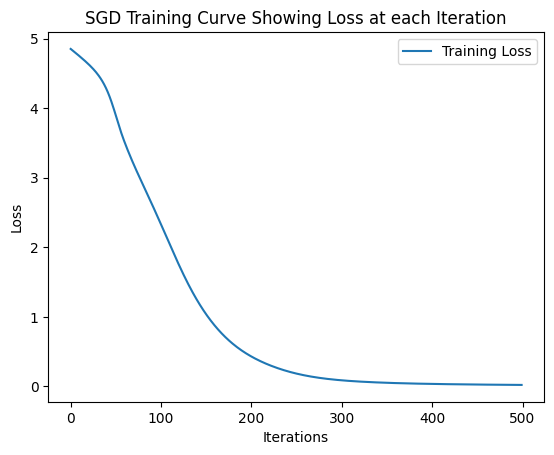

Final Training Loss: 0.021211159927118733


In [ ]:
# produce a single batch of data
X_small = X_chpnop23[:100]
t_small = t_chpnop23[:100]
# your model should be able to achieve close to 0 training loss
# i.e. within 500 iterations/epochs
model = MLPModel()
train_sgd(model, X_train=X_small, t_train=t_small, alpha=0.2, batch_size=100, n_epochs=500)

## Part 5. Music Generation

Now that you are reasonably sure that your model is implemented correctly, let's
train a model on some of Chopin's pieces.

There is still the question of splitting the training/validation/test data.
This is actually a pretty nuanced questions.
We would like to have a validation set to be able to detect and prevent overfitting.
However, the way that we intend to use this model is unlike the models built in previous labs:
we would like to repeatedly apply this model to generate new music! Thus, the model loss (and accuracy)
are actually poor measures for how well a model would perform when generating music.

Since loss/accuracy are poor measurements for model generalization, we will not set aside a test set.
Instead, we will need a human (yes, you!) to judge how well our model is doing.
We therefore won't concern ourselves too much with having a
well split training/validation/test set where the test set is "uncontaminated" and distinct
from the training set.

We will still hold out a few pieces as part of our validation set. However,
keep in mind that validation loss/accuracy may not be good indicators of model performance.

In [ ]:
def generate_data_for_files(files):
    Xs, ts = [], []
    for file in files:
        notes = get_midi_file_notes(file)
        D = gen_input_output(notes)
        X, t = get_X_t(D)
        Xs.append(X)
        ts.append(t)
    X = np.concatenate(Xs, axis=0)
    t = np.concatenate(ts, axis=0)
    return X, t

import glob
files = [file for file in glob.glob('data/chopin/*_simplified.mid')]
X_train, t_train = generate_data_for_files(files[:30])
X_valid, t_valid = generate_data_for_files(files[30:])

**Task**: Train the model on this data set. This code may take several minutes to run.
Again, the validation loss is, unfortunately, a poor measure of the quality of music generated.
So we should not read too much into the validation loss too much.
Instead, we will need to use other methods (e.g. human evaluation) to evaluate music quality
and assess under/overfitting.

Training for ~30 epochs may take several minutes.

In [ ]:
# Run this code!
model = MLPModel()
train_sgd(model, alpha=0.1, X_train=X_train, t_train=t_train, X_valid=X_valid, t_valid=t_valid, batch_size=100, n_epochs=30)

**Task**: Now that we have a trained model, we can use your function
`generate_piece` from earlier to generate a new piece of music
using our model, one note at a time.

Run the below code to generate a piece of music, starting from the first 20
notes from notes_chpnop23.
Generate `CONTEXT_LENGTH` number of new notes.

In [ ]:
seed = notes_chpnop23[:CONTEXT_LENGTH]

notes = None # TODO
generate_midi(notes, 'chpnop23_comp.mid')
play_midi('chpnop23_comp.mid')

**Optional Task**: Try some other seeds, and see what music you can generate with this model!
We included music from a different composer (Debussy) in the data file. You can also try
to build a model with Debussy's music as training data, and see how that model differs.

In [ ]:
# TODO

## Part 6. Limitations

**Graded Task**:
Your model may produce a few musical-sounding notes to continue your piece.
However, if we set `max_len` large enough,
sooner or later your model will likely produce the same sequence of
notes over and over again.  Why do you think is the case? How is this
behaviour related
to the limitation of the model architecture? Recall that we are using
a fixed number of previous notes to predict the next note.

In [ ]:
# The repetition occurs because the MLP model uses a fixed context length
# If the model encounters a sequence of notes that leads to the same prediction repeatedly, it will generate a loop of identical sequences. This is because the model has no memory beyond the fixed context window。
#

In practice, practitioners shy away from using models like this. In CSC413, we will explore more advanced models such as Recurrent Neural Networks (RNNs) and Transformers, which are more powerful for handling such tasks.